## Imports

Analyzing feature: Temperature_C
> train size: 1856
> val size: 462
> test size: 1538
> test anomalies: 312 (20.3%)

===== NAS ARCHITECTURE =====
Using NAS-discovered architecture:
Block 1: {'conv_n_out_channels': 16, 'conv_kernel_size': 15, 'pool_type': 'avg', 'pool_kernel_size': 7, 'norm_type': 'batch', 'act_funcs': 'none'}
Block 2: {'conv_n_out_channels': 16, 'conv_kernel_size': 15, 'pool_type': 'none', 'pool_kernel_size': 7, 'norm_type': 'batch', 'act_funcs': 'none'}

Using device: cpu
AE(
  (encoder): ModuleList(
    (0): EncoderBlock(
      (encoding_block): Sequential(
        (conv): Conv1d(1, 16, kernel_size=(15,), stride=(1,), padding=(7,))
        (pool): AvgPool1d(kernel_size=(7,), stride=(2,), padding=(0,))
        (norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): EncoderBlock(
      (encoding_block): Sequential(
        (conv): Conv1d(16, 16, kernel_size=(15,), stride=(1,), padding=(7,))
        (norm): BatchNor

Epoch 1/10: 100%|██████████| 58/58 [00:01<00:00, 44.07it/s]


Epoch 1/10 - Loss: 3.490085 - Time: 0:00:01.334814


Epoch 2/10: 100%|██████████| 58/58 [00:01<00:00, 45.22it/s]


Epoch 2/10 - Loss: 2.662575 - Time: 0:00:01.283438


Epoch 3/10: 100%|██████████| 58/58 [00:01<00:00, 45.63it/s]


Epoch 3/10 - Loss: 2.269890 - Time: 0:00:01.271934


Epoch 4/10: 100%|██████████| 58/58 [00:01<00:00, 46.19it/s]


Epoch 4/10 - Loss: 1.958155 - Time: 0:00:01.256648


Epoch 5/10: 100%|██████████| 58/58 [00:01<00:00, 45.07it/s]


Epoch 5/10 - Loss: 1.708554 - Time: 0:00:01.287948


Epoch 6/10: 100%|██████████| 58/58 [00:01<00:00, 44.83it/s]


Epoch 6/10 - Loss: 1.505915 - Time: 0:00:01.294842


Epoch 7/10: 100%|██████████| 58/58 [00:01<00:00, 46.18it/s]


Epoch 7/10 - Loss: 1.343472 - Time: 0:00:01.256910


Epoch 8/10: 100%|██████████| 58/58 [00:01<00:00, 46.39it/s]


Epoch 8/10 - Loss: 1.206685 - Time: 0:00:01.251177


Epoch 9/10: 100%|██████████| 58/58 [00:01<00:00, 43.33it/s]


Epoch 9/10 - Loss: 1.097917 - Time: 0:00:01.339594


Epoch 10/10: 100%|██████████| 58/58 [00:01<00:00, 43.98it/s]


Epoch 10/10 - Loss: 1.009224 - Time: 0:00:01.319820

Training Complete in 0:00:12.897459


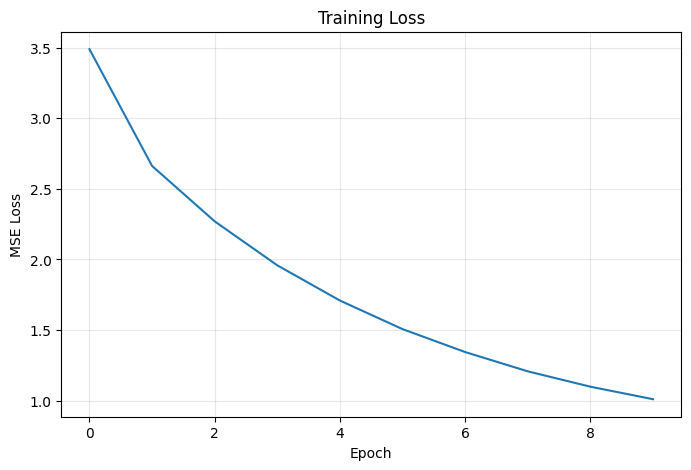


===== SETTING THRESHOLD =====


Validating: 100%|██████████| 462/462 [00:00<00:00, 1905.30it/s]


Threshold set at 99th percentile: 3.340833


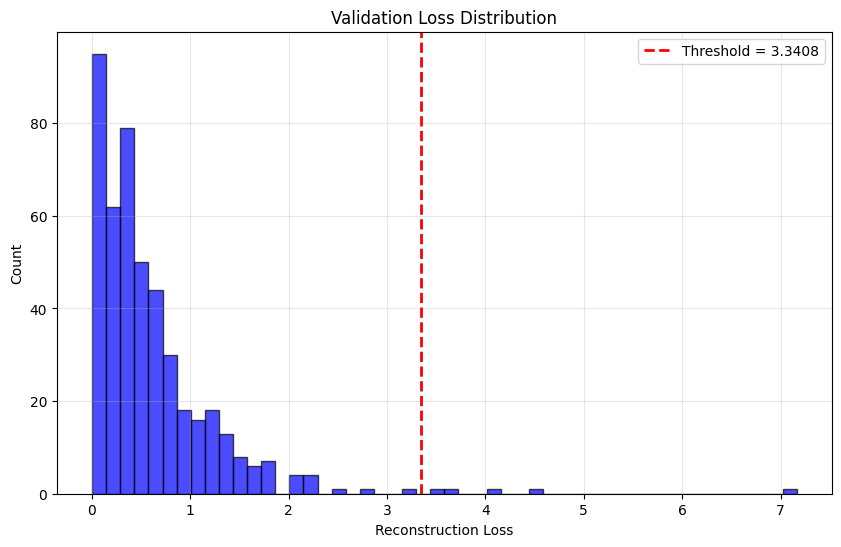


===== TESTING =====


Testing: 100%|██████████| 1538/1538 [00:00<00:00, 2384.87it/s]



===== RESULTS =====
True Positives: 121
False Positives: 16
True Negatives: 1210
False Negatives: 191

Precision: 0.8832
Recall: 0.3878
F1-Score: 0.5390


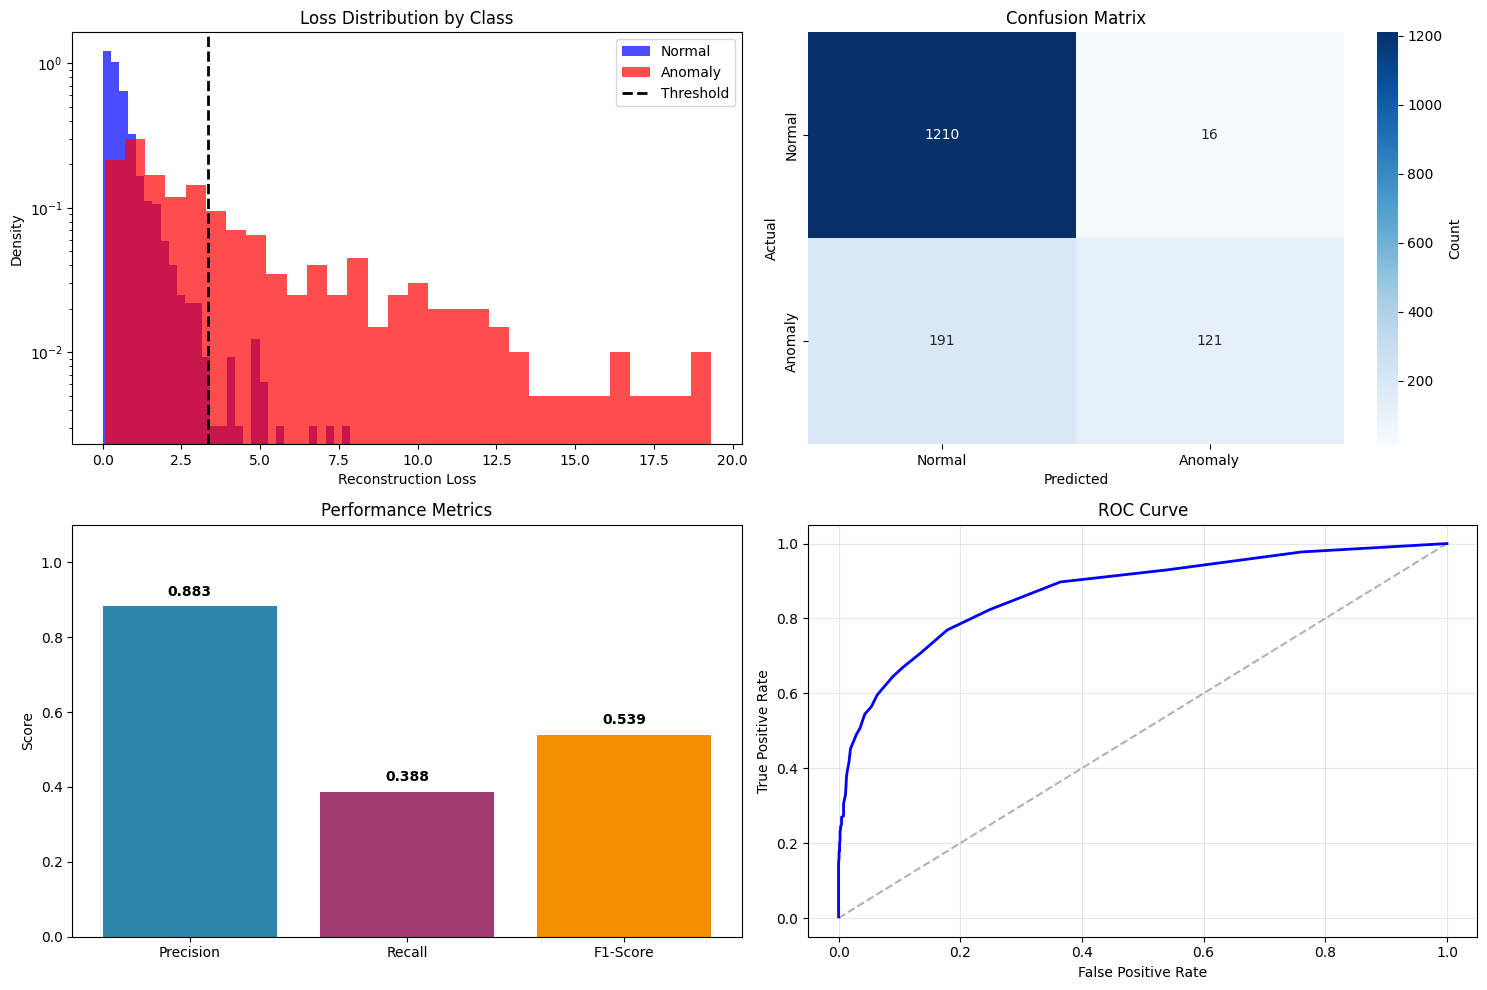


===== EXAMPLE RECONSTRUCTIONS =====


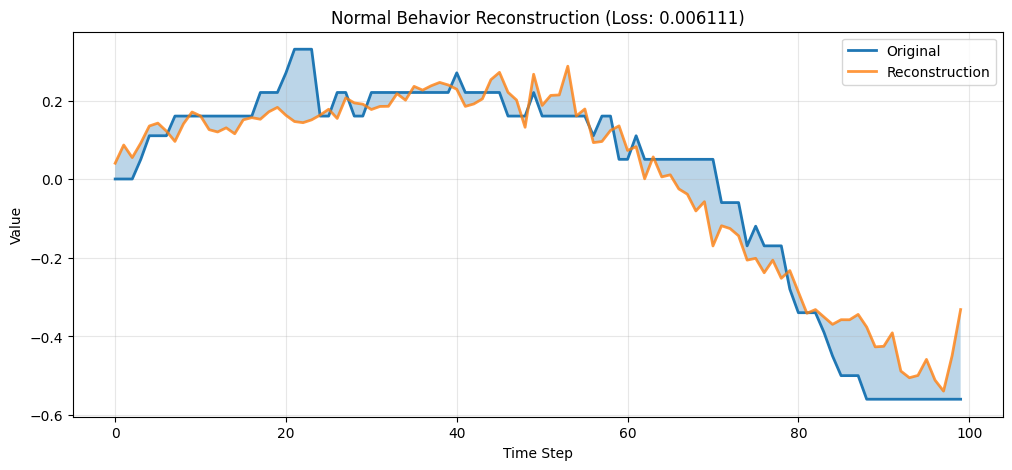

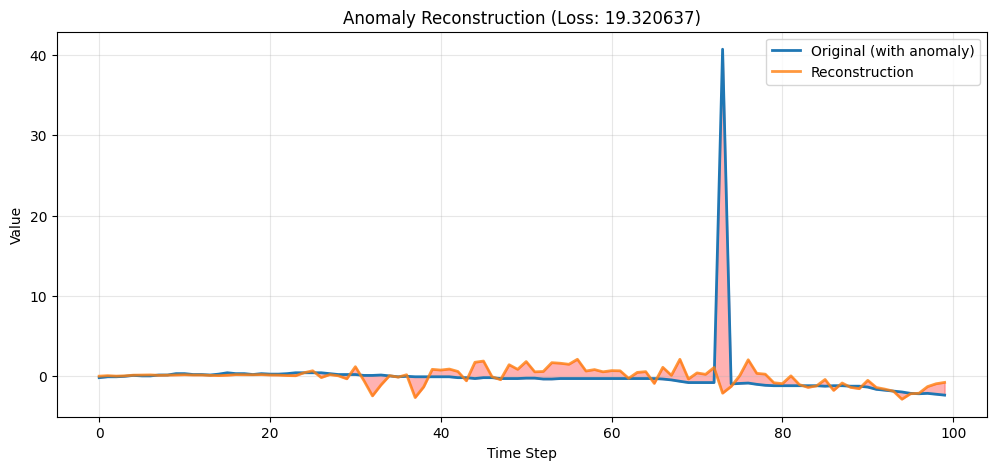


===== SUMMARY =====
Feature: Temperature_C
Architecture: NAS-optimized
F1-Score: 0.5390
Precision: 0.8832
Recall: 0.3878
Threshold: 3.340833


In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import timedelta
from tqdm import tqdm 
import time
import random
import os

# Set random seeds for reproducibility
seed = 19
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Hyperparameters
batch_size = 32
lr = 1e-3         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 10

# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.data = dataset.drop(["gt"], axis=1)
        self.targets = dataset["gt"]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        data = torch.from_numpy(np.array(row)).float().reshape(1, -1)
        target = self.targets.iloc[idx]
        # Normalization: subtract mean
        data = data - data.mean()
        return data, target

# ===== CHOOSE YOUR FEATURE =====
# Uncomment the feature you want to analyze:

# Option 1: Temperature (what you used for NAS)
feature_name = "Temperature_C"
train_path = '../dataset/synth_ts_data/train_IHAMPS1_Temperature_C.csv'
test_path = '../dataset/synth_ts_data/test_IHAMPS1_Temperature_C.csv'

# Option 2: Humidity
# feature_name = "Humidity_%"
# train_path = '../dataset/synth_ts_data/train_IHAMPS1_Humidity_%.csv'
# test_path = '../dataset/synth_ts_data/test_IHAMPS1_Humidity_%.csv'

# Option 3: Pressure
# feature_name = "Pressure_hPa"
# train_path = '../dataset/synth_ts_data/train_IHAMPS1_Pressure_hPa.csv'
# test_path = '../dataset/synth_ts_data/test_IHAMPS1_Pressure_hPa.csv'

print(f"Analyzing feature: {feature_name}")

# Load data
full_dataset = pd.read_csv(train_path, index_col=False)
train_size = int(0.8 * len(full_dataset))

# Create train/validation split
train_dataset_df = full_dataset[:train_size]
train_dataset = Dataset(train_dataset_df)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

val_dataset_df = full_dataset[train_size+1:]
val_dataset = Dataset(val_dataset_df)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1)

# Load test data (contains anomalies)
test_dataset_df = pd.read_csv(test_path, index_col=False)
test_dataset = Dataset(test_dataset_df)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

print(f"> train size: {len(train_loader)*batch_size}") 
print(f"> val size: {len(val_loader)}")
print(f"> test size: {len(test_loader)}")
print(f"> test anomalies: {test_dataset_df['gt'].sum()} ({test_dataset_df['gt'].sum()/len(test_dataset_df)*100:.1f}%)")

# Encoder block
class EncoderBlock(nn.Module):
    def __init__(self, enc_conv_layer, enc_pool_layer=None, enc_norm_layer=None, enc_act_func=None):
        super(EncoderBlock, self).__init__()
        self.encoding_block = nn.Sequential()
        self.encoding_block.add_module('conv', enc_conv_layer)
        if enc_pool_layer is not None: 
            self.encoding_block.add_module('pool', enc_pool_layer)
        if enc_norm_layer is not None: 
            self.encoding_block.add_module('norm', enc_norm_layer)
        if enc_act_func is not None: 
            self.encoding_block.add_module('act', enc_act_func)
    
    def forward(self, x):
        return self.encoding_block(x)

# Decoder block    
class DecoderBlock(nn.Module):
    def __init__(self, dec_tconv_layer, dec_norm_layer=None, dec_act_func=None):
        super(DecoderBlock, self).__init__()
        self.decoding_block = nn.Sequential()
        self.decoding_block.add_module('tconv', dec_tconv_layer)
        if dec_norm_layer is not None: 
            self.decoding_block.add_module('norm', dec_norm_layer)
        if dec_act_func is not None: 
            self.decoding_block.add_module('act', dec_act_func)
        
    def forward(self, x):
        return self.decoding_block(x)

# Architecture search space (must match your NAS configuration)
conv_n_out_channels = [1, 2, 4, 8, 16, 32]
conv_kernel_size = [3, 5, 7, 10, 15]
pool_type = ['none', 'max', 'avg']
pool_kernel_size = [3, 5, 7]
norm_type = ['none', 'batch', 'instance']
act_funcs = ['none', 'sigmoid', 'tanh', 'relu', 'elu']
n_blocks = 2
len_block = 6

def translate_sequence(sequence):
    """Decode sequence to architecture description"""
    i = 0
    dec_seq = []
    while i < len(sequence):
        block = sequence[i: i+len_block]
        i += len_block
        dec_block = {
            "conv_n_out_channels": conv_n_out_channels[block[0]],
            "conv_kernel_size": conv_kernel_size[block[1]],
            "pool_type": pool_type[block[2]],
            "pool_kernel_size": pool_kernel_size[block[3]],
            "norm_type": norm_type[block[4]],
            "act_funcs": act_funcs[block[5]]
        }
        dec_seq.append(dec_block)
    return dec_seq

# Autoencoder model
class AE(nn.Module):
    def __init__(self, sequence):
        super(AE, self).__init__()
        encoder_blocks_list, decoder_blocks_list = self.build_model(sequence)
        self.encoder = nn.ModuleList(encoder_blocks_list)
        self.decoder = nn.ModuleList(decoder_blocks_list)
    
    def build_model(self, sequence):
        """Build model architecture from sequence"""
        encoder_blocks_list = []
        decoder_blocks_list = []
        tr_seq = translate_sequence(sequence)
        
        conv_n_in_channels = 1
        prev_enc_out_width = 100
        
        for i, block in enumerate(tr_seq):
            conv_n_out_channels = block['conv_n_out_channels']
            conv_kernel_size = block['conv_kernel_size']
            pool_type = block['pool_type']
            pool_kernel_size = block['pool_kernel_size']
            norm_type = block['norm_type']
            act_func = block['act_funcs']
            
            # Encoder parameters
            conv_pad = conv_kernel_size // 2
            conv_stride = 1
            pool_stride = 2
            
            conv_out_width = (prev_enc_out_width + 2*conv_pad - conv_kernel_size)//conv_stride + 1
            pool_out_width = (conv_out_width-pool_kernel_size)//pool_stride + 1 if pool_type in ['avg', 'max'] else conv_out_width
            
            # Encoder layers
            enc_conv_layer = nn.Conv1d(conv_n_in_channels, conv_n_out_channels, conv_kernel_size, conv_stride, conv_pad)
            
            if pool_type == 'avg': 
                enc_pool_layer = nn.AvgPool1d(pool_kernel_size, pool_stride)
            elif pool_type == 'max': 
                enc_pool_layer = nn.MaxPool1d(pool_kernel_size, pool_stride)
            else: 
                enc_pool_layer = None
                
            if norm_type == 'batch': 
                enc_norm_layer = nn.BatchNorm1d(conv_n_out_channels)
            elif norm_type == 'instance': 
                enc_norm_layer = nn.InstanceNorm1d(conv_n_out_channels)
            else: 
                enc_norm_layer = None
                
            if act_func == 'relu': 
                enc_act_func = nn.ReLU()
            elif act_func == 'elu': 
                enc_act_func = nn.ELU()
            elif act_func == 'sigmoid': 
                enc_act_func = nn.Sigmoid()
            elif act_func == 'tanh': 
                enc_act_func = nn.Tanh()
            else: 
                enc_act_func = None
                
            encoder_blocks_list.append(
                EncoderBlock(enc_conv_layer, enc_pool_layer, enc_norm_layer, enc_act_func)
            )
            
            # Decoder parameters
            convT_stride = 1
            convT_in_width = pool_out_width
            convT_out_width = prev_enc_out_width
            convT_kernel_size = int(convT_out_width - (convT_in_width - 1) * convT_stride)
            
            dec_tconv_layer = nn.ConvTranspose1d(
                conv_n_out_channels, conv_n_in_channels, 
                kernel_size=convT_kernel_size, stride=convT_stride
            )
            
            # Decoder layers
            if norm_type == 'batch': 
                dec_norm_layer = nn.BatchNorm1d(conv_n_in_channels)
            elif norm_type == 'instance': 
                dec_norm_layer = nn.InstanceNorm1d(conv_n_in_channels)
            else: 
                dec_norm_layer = None
                
            if act_func == 'relu': 
                dec_act_func = nn.ReLU()
            elif act_func == 'elu': 
                dec_act_func = nn.ELU()
            elif act_func == 'sigmoid': 
                dec_act_func = nn.Sigmoid()
            elif act_func == 'tanh': 
                dec_act_func = nn.Tanh()
            else: 
                dec_act_func = None
                
            decoder_blocks_list.insert(0, 
                DecoderBlock(dec_tconv_layer, dec_norm_layer, dec_act_func)
            )
            
            conv_n_in_channels = conv_n_out_channels
            prev_enc_out_width = pool_out_width
            
        return encoder_blocks_list, decoder_blocks_list
    
    def forward(self, x):
        # Encode
        encode = x
        for encoder_block in self.encoder:
            encode = encoder_block(encode)
        
        # Decode
        decode = encode
        for decoder_block in self.decoder:
            decode = decoder_block(decode)
        
        return decode

# ===== USE YOUR NAS ARCHITECTURE =====
# Your best NAS architecture:
# Block 1: Conv(16, k=15) → AvgPool(7) → BatchNorm → None
# Block 2: Conv(16, k=15) → None → BatchNorm → None

# Encoded version of your best architecture
best_nas_architecture = [
    4, 4, 2, 2, 1, 0,  # Block 1: 16 filters, kernel 15, avg pool, pool kernel 7, batch norm, no activation
    4, 4, 0, 2, 1, 0   # Block 2: 16 filters, kernel 15, no pool, (pool kernel 7 ignored), batch norm, no activation
]

print("\n===== NAS ARCHITECTURE =====")
print("Using NAS-discovered architecture:")
for i, block in enumerate(translate_sequence(best_nas_architecture)):
    print(f"Block {i+1}: {block}")
print("="*30 + "\n")

# Initialize model, loss, optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

model = AE(best_nas_architecture)
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training
metrics = defaultdict(list)
model.train()

print("\n===== TRAINING =====")
start = time.time()

for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    
    for i, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
        original_ts = data.to(device)
        reconstructed_ts = model(original_ts)
        loss = criterion(original_ts, reconstructed_ts)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    metrics['train_loss'].append(epoch_loss)
    
    ep_end = time.time()
    print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.6f} - Time: {timedelta(seconds=ep_end-ep_start)}')

end = time.time()
print(f'\nTraining Complete in {timedelta(seconds=end-start)}')

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(metrics['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Validation - Set threshold
print("\n===== SETTING THRESHOLD =====")
model.eval()
val_losses = []

with torch.no_grad():
    for i, (data, _) in enumerate(tqdm(val_loader, desc='Validating')):
        original_ts = data.to(device)
        reconstructed_ts = model(original_ts)
        loss = criterion(original_ts, reconstructed_ts)
        val_losses.append(loss.item())

# Set threshold at 99th percentile
loss_threshold = np.percentile(val_losses, q=99)
print(f"Threshold set at 99th percentile: {loss_threshold:.6f}")

# Visualize loss distribution
plt.figure(figsize=(10, 6))
plt.hist(val_losses, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(loss_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {loss_threshold:.4f}')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Count')
plt.title('Validation Loss Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Testing - Evaluate on test data with anomalies
print("\n===== TESTING =====")
tp = fp = tn = fn = 0
test_losses = []
test_labels = []

model.eval()
with torch.no_grad():
    for i, (data, gt) in enumerate(tqdm(test_loader, desc='Testing')):
        original_ts = data.to(device)
        reconstructed_ts = model(original_ts)
        loss = criterion(original_ts, reconstructed_ts).item()
        
        test_losses.append(loss)
        test_labels.append(gt.item())
        
        if loss >= loss_threshold:
            if gt == 1: tp += 1
            else: fp += 1
        else:
            if gt == 1: fn += 1
            else: tn += 1

# Calculate metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n===== RESULTS =====")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Loss distribution by class
ax = axes[0, 0]
normal_losses = [l for l, g in zip(test_losses, test_labels) if g == 0]
anomaly_losses = [l for l, g in zip(test_losses, test_labels) if g == 1]

ax.hist(normal_losses, bins=30, alpha=0.7, label='Normal', color='blue', density=True)
ax.hist(anomaly_losses, bins=30, alpha=0.7, label='Anomaly', color='red', density=True)
ax.axvline(loss_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold')
ax.set_xlabel('Reconstruction Loss')
ax.set_ylabel('Density')
ax.set_title('Loss Distribution by Class')
ax.legend()
ax.set_yscale('log')

# 2. Confusion Matrix
ax = axes[0, 1]
conf_matrix = [[tn, fp], [fn, tp]]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'], 
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# 3. Performance metrics
ax = axes[1, 0]
metrics_dict = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}
bars = ax.bar(metrics_dict.keys(), metrics_dict.values(), color=['#2E86AB', '#A23B72', '#F18F01'])
ax.set_ylim(0, 1.1)
ax.set_ylabel('Score')
ax.set_title('Performance Metrics')

for bar, value in zip(bars, metrics_dict.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. ROC-style plot
ax = axes[1, 1]
sorted_indices = np.argsort(test_losses)
sorted_losses = np.array(test_losses)[sorted_indices]
sorted_labels = np.array(test_labels)[sorted_indices]

tpr_list = []
fpr_list = []

for threshold in np.linspace(min(test_losses), max(test_losses), 100):
    tp_temp = np.sum((sorted_losses >= threshold) & (sorted_labels == 1))
    fp_temp = np.sum((sorted_losses >= threshold) & (sorted_labels == 0))
    fn_temp = np.sum((sorted_losses < threshold) & (sorted_labels == 1))
    tn_temp = np.sum((sorted_losses < threshold) & (sorted_labels == 0))
    
    tpr = tp_temp / (tp_temp + fn_temp) if (tp_temp + fn_temp) > 0 else 0
    fpr = fp_temp / (fp_temp + tn_temp) if (fp_temp + tn_temp) > 0 else 0
    
    tpr_list.append(tpr)
    fpr_list.append(fpr)

ax.plot(fpr_list, tpr_list, 'b-', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'anomaly_detection_results_{feature_name}.png', dpi=300, bbox_inches='tight')
plt.show()

# Example reconstructions
print("\n===== EXAMPLE RECONSTRUCTIONS =====")

# Find a good normal example
normal_examples = [(i, loss) for i, (loss, label) in enumerate(zip(test_losses, test_labels)) 
                   if label == 0 and loss < loss_threshold]
if normal_examples:
    idx, loss = min(normal_examples, key=lambda x: x[1])
    data, _ = test_dataset[idx]
    
    plt.figure(figsize=(12, 5))
    original = data.numpy().flatten()
    reconstructed = model(data.unsqueeze(0).to(device)).cpu().detach().numpy().flatten()
    
    plt.plot(original, label='Original', linewidth=2)
    plt.plot(reconstructed, label='Reconstruction', linewidth=2, alpha=0.8)
    plt.fill_between(range(len(original)), original, reconstructed, alpha=0.3)
    plt.title(f'Normal Behavior Reconstruction (Loss: {loss:.6f})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Find a good anomaly example
anomaly_examples = [(i, loss) for i, (loss, label) in enumerate(zip(test_losses, test_labels)) 
                    if label == 1 and loss > loss_threshold]
if anomaly_examples:
    idx, loss = max(anomaly_examples, key=lambda x: x[1])
    data, _ = test_dataset[idx]
    
    plt.figure(figsize=(12, 5))
    original = data.numpy().flatten()
    reconstructed = model(data.unsqueeze(0).to(device)).cpu().detach().numpy().flatten()
    
    plt.plot(original, label='Original (with anomaly)', linewidth=2)
    plt.plot(reconstructed, label='Reconstruction', linewidth=2, alpha=0.8)
    plt.fill_between(range(len(original)), original, reconstructed, alpha=0.3, color='red')
    plt.title(f'Anomaly Reconstruction (Loss: {loss:.6f})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print(f"\n===== SUMMARY =====")
print(f"Feature: {feature_name}")
print(f"Architecture: NAS-optimized")
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Threshold: {loss_threshold:.6f}")

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import timedelta
from tqdm import tqdm 
import time
import random
import os


In [4]:
seed = 19

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Hyper-parameters

In [5]:
batch_size = 32
lr = 1e-3         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 10

## Data Loading

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.data = dataset.drop(["gt"], axis=1)
        self.targets = dataset["gt"]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        data = torch.from_numpy(np.array(row)).float().reshape(1, -1)
        target = self.targets.iloc[idx]
        # normalization 
        # data = (data - data.mean()) / (data.std() if data.std() else 1)        
        # data = (data - data.min()) / (data.max() - data.min() if (data.max()-data.min()) else 1) * 10
        # data = data - data.mean() + data.max() - data.min()
        data = data - data.mean()
        return data, target

In [7]:
full_dataset = pd.read_csv('../dataset/synth_ts_data/train_hum.csv', index_col=False)
train_size = int(0.8 * len(full_dataset))

train_dataset_df = full_dataset[:train_size]
train_dataset = Dataset(train_dataset_df)
train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
        )

val_dataset_df = full_dataset[train_size+1:]
val_dataset = Dataset(val_dataset_df)
val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=1,
        )

test_dataset_df = pd.read_csv('../dataset/synth_ts_data/test_hum.csv', index_col=False)
test_dataset = Dataset(test_dataset_df)
test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=1,
        )

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/synth_ts_data/train_hum.csv'

In [252]:
print(f"> train size: {len(train_loader)*batch_size}") 
print(f"> val size: {len(val_loader)}")
print(f"> test size: {len(test_loader)}")

> train size: 16192
> val size: 4045
> test size: 5055


## AE Model Definition

In [253]:
class EncoderBlock(nn.Module):
    def __init__(self, enc_conv_layer, enc_pool_layer=None, enc_norm_layer=None, enc_act_func=None):
        super(EncoderBlock, self).__init__()
        self.encoding_block = nn.Sequential()
        self.encoding_block.add_module('conv', enc_conv_layer)
        if enc_pool_layer!=None: self.encoding_block.add_module('pool', enc_pool_layer)
        if enc_norm_layer!= None: self.encoding_block.add_module('norm', enc_norm_layer)
        if enc_act_func!= None: self.encoding_block.add_module('act', enc_act_func)

    def forward(self, x):
        return self.encoding_block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, dec_tconv_layer, dec_norm_layer=None, dec_act_func=None):
        super(DecoderBlock, self).__init__()
        self.decoding_block = nn.Sequential()
        self.decoding_block.add_module('tconv', dec_tconv_layer)
        if dec_norm_layer!=None: self.decoding_block.add_module('norm', dec_norm_layer)
        if dec_act_func!= None: self.decoding_block.add_module('act', dec_act_func)
        
    def forward(self, x):
        return self.decoding_block(x)
    

conv_n_out_channels = [1, 2, 4, 8, 16, 32]
conv_kernel_size = [3, 5, 7, 10, 15]
pool_type = ['none', 'max', 'avg']
pool_kernel_size = [3, 5, 7]
norm_type = ['none', 'batch', 'instance']
act_funcs = ['none', 'sigmoid', 'tanh', 'relu', 'elu']

n_blocks = 2
len_block = 6

def translate_sequence(sequence):
    # assert len(sequence)==len_block*n_blocks
    i = 0
    dec_seq = []
    while i<len(sequence):
        block = sequence[i: i+len_block]
        i += len_block
        dec_block = {
            "conv_n_out_channels,": conv_n_out_channels[block[0]],
            "conv_kernel_size,": conv_kernel_size[block[1]],
            "pool_type,": pool_type[block[2]],
            "pool_kernel_size": pool_kernel_size[block[3]],
            "norm_type,": norm_type[block[4]],
            "act_funcs,": act_funcs[block[5]]
        }
        dec_seq.append(dec_block)
    return dec_seq


class AE(nn.Module):

    def __init__(self, sequence):
        super(AE, self).__init__()
        encoder_blocks_list, decoder_blocks_list = self.build_model(sequence)
        self.encoder = nn.ModuleList(encoder_blocks_list)
        self.decoder = nn.ModuleList(decoder_blocks_list)


    def build_model(self, sequence):
        # builds model architecture from token sequence
        encoder_blocks_list = []
        decoder_blocks_list = []
        tr_seq = translate_sequence(sequence)
        conv_n_in_channels = 1
        prev_enc_out_width = 100

        for i, block in enumerate(tr_seq):
            conv_n_out_channels, conv_kernel_size, pool_type, pool_kernel_size, norm_type, act_func = block.values()
            print(block.values())

            # Encoder
            # params
            conv_pad = 1
            conv_stride = 1
            pool_stride = 2
            conv_out_width = (prev_enc_out_width + 2*conv_pad - conv_kernel_size)//conv_stride + 1
            pool_out_width = (conv_out_width-pool_kernel_size)//pool_stride + 1 if pool_type in ['avg', 'max'] else conv_out_width
            
            # layers choices
            enc_conv_layer = nn.Conv1d(conv_n_in_channels, conv_n_out_channels, conv_kernel_size, conv_stride, conv_pad)

            if pool_type=='avg': enc_pool_layer = nn.AvgPool1d(pool_kernel_size, pool_stride)
            elif pool_type=='max': enc_pool_layer = nn.MaxPool1d(pool_kernel_size, pool_stride)
            else: enc_pool_layer = None

            if norm_type=='batch': enc_norm_layer = nn.BatchNorm1d(conv_n_out_channels)
            elif norm_type=='instance': enc_norm_layer = nn.InstanceNorm1d(conv_n_out_channels)
            else: enc_norm_layer=None

            if act_func=='relu': enc_act_func = nn.ReLU()
            elif act_func=='elu': enc_act_func = nn.ELU()
            elif act_func=='sigmoid': enc_act_func = nn.Sigmoid()
            elif act_func=='tanh': enc_act_func = nn.Tanh()
            else: enc_act_func = None

            encoder_blocks_list.append(
                EncoderBlock(
                    enc_conv_layer,
                    enc_pool_layer,
                    enc_norm_layer,
                    enc_act_func
                )
            )

            # Decoder
            # params
            convT_stride = 1
            convT_in_width = pool_out_width
            convT_out_width = prev_enc_out_width
            convT_kernel_size = int(convT_out_width-(convT_in_width-1)*convT_stride)

            dec_tconv_layer = nn.ConvTranspose1d(conv_n_out_channels, conv_n_in_channels, kernel_size=convT_kernel_size, stride=convT_stride)
            
            # layers choices
            if norm_type=='batch': dec_norm_layer = nn.BatchNorm1d(conv_n_in_channels)
            elif norm_type=='instance': dec_norm_layer = nn.InstanceNorm1d(conv_n_in_channels)
            else: dec_norm_layer=None

            if act_func=='relu': dec_act_func = nn.ReLU()
            elif act_func=='elu': dec_act_func = nn.ELU()
            elif act_func=='sigmoid': dec_act_func = nn.Sigmoid()
            elif act_func=='tanh': dec_act_func = nn.Tanh()
            else: dec_act_func = None

            decoder_blocks_list.insert(
                0,
                DecoderBlock(
                    dec_tconv_layer,
                    dec_norm_layer,
                    dec_act_func
                )
            )

            conv_n_in_channels = conv_n_out_channels
            prev_enc_out_width = pool_out_width

        return encoder_blocks_list, decoder_blocks_list


    def forward(self, x):
        # print(self.encoder)
        # print(self.decoder)
        encode = x
        # print('inp',encode.shape)
        for encoder_block in self.encoder:
            encode = encoder_block(encode)
        #     print('enc',encode.shape)
        # print(' z ',encode.shape)
        decode = encode
        for decoder_block in self.decoder:
            decode = decoder_block(decode)
            # print('dec',decode.shape)
        return decode

## Training

In [254]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using:', device)
model = AE([2,3,0,2,2,0, 3,0,2,2,1,1, 4,0,0,0,1,2])
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)
model

using: cuda
dict_values([4, 10, 'none', 7, 'instance', 'none'])
dict_values([8, 3, 'avg', 7, 'batch', 'sigmoid'])
dict_values([16, 3, 'none', 3, 'batch', 'tanh'])


AE(
  (encoder): ModuleList(
    (0): EncoderBlock(
      (encoding_block): Sequential(
        (conv): Conv1d(1, 4, kernel_size=(10,), stride=(1,), padding=(1,))
        (norm): InstanceNorm1d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (1): EncoderBlock(
      (encoding_block): Sequential(
        (conv): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (pool): AvgPool1d(kernel_size=(7,), stride=(2,), padding=(0,))
        (norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Sigmoid()
      )
    )
    (2): EncoderBlock(
      (encoding_block): Sequential(
        (conv): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Tanh()
      )
    )
  )
  (decoder): ModuleList(
    (0): DecoderBlock(
      (decoding_block): Sequential(
        (tconv): ConvTranspose1

In [255]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for i, (data, _) in tqdm(enumerate(train_loader), disable=True):
        original_ts = data.to(device)
        reconstructed_ts = model(original_ts)
        loss = criterion(original_ts, reconstructed_ts)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_loader)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 1/10
[LOSS] 0.9719539284706116
Epoch Complete in 0:00:05.036824
-----------------------------------------------
[EPOCH] 2/10
[LOSS] 0.9259258046922948
Epoch Complete in 0:00:05.024660
-----------------------------------------------
[EPOCH] 3/10
[LOSS] 0.9197245251991061
Epoch Complete in 0:00:04.995142
-----------------------------------------------
[EPOCH] 4/10
[LOSS] 0.9162973702660663
Epoch Complete in 0:00:04.868358
-----------------------------------------------
[EPOCH] 5/10
[LOSS] 0.9138389129648096
Epoch Complete in 0:00:05.010443
-----------------------------------------------
[EPOCH] 6/10
[LOSS] 0.9118473869067407
Epoch Complete in 0:00:04.917346
-----------------------------------------------
[EPOCH] 7/10
[LOSS] 0.910111419061427
Epoch Complete in 0:00:05.343085
-----------------------------------------------
[EPOCH] 8/10
[LOSS] 0.9085046747927609
Epoch Complete in 0:00:04.969172
-----------------------------------------

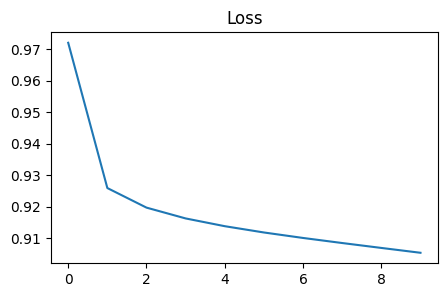

In [256]:
_, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

## Choosing threshold using Valid data

In [257]:
model.eval()
losses = []
for i, (data, _) in tqdm(enumerate(val_loader)):
    original_ts = data.to(device)
    reconstructed_ts = model(original_ts)
    loss = criterion(original_ts, reconstructed_ts)
    losses.append(loss.item())

4045it [00:06, 587.55it/s]


In [258]:
loss_threshold = np.percentile(losses, q=99)
print(loss_threshold)

1.0388856363296508


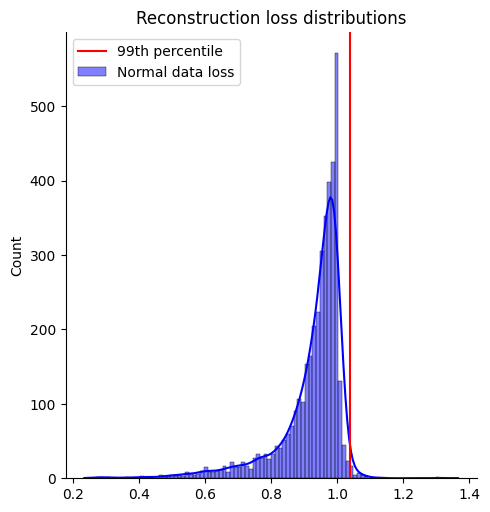

In [259]:
sns.displot(losses, bins=100, kde=True, color='blue', label="Normal data loss")
plt.axvline(loss_threshold, 0.0, 10, color='r', label="99th percentile")
plt.title("Reconstruction loss distributions")
plt.legend()
plt.show()

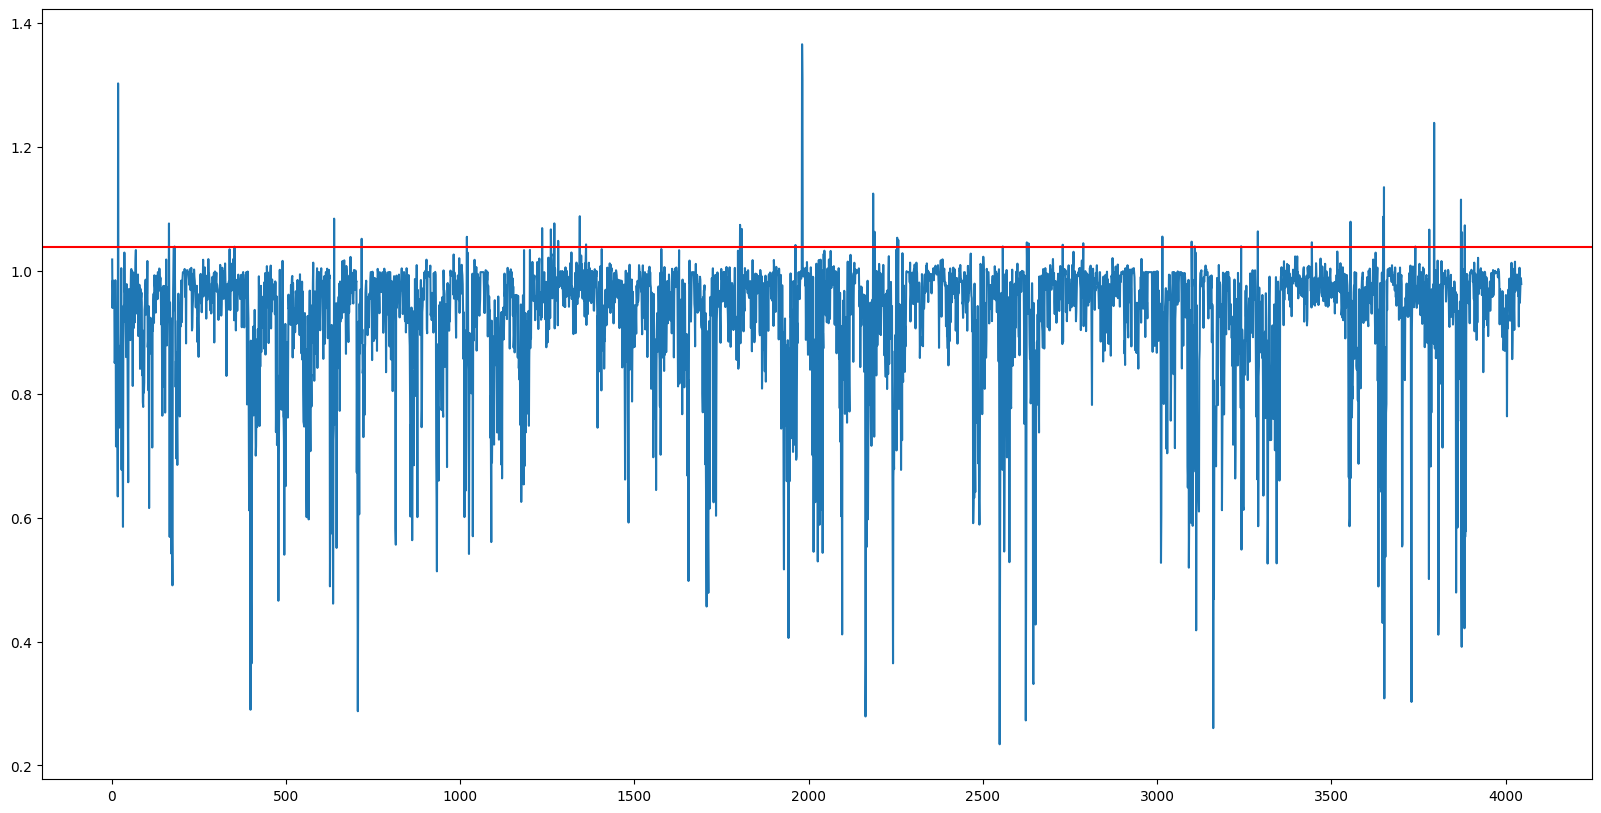

In [260]:
plt.figure(figsize=(20,10))
plt.plot(range(1, len(losses)+1), losses)
plt.axhline(loss_threshold, 0.0, 10, color='r')

## Anomaly detection on contaminated test data

5055it [00:09, 542.96it/s]


[TP] 939	[FP] 77
[FN] 57	[TN] 3982
F1 score = 0.9333996023856859


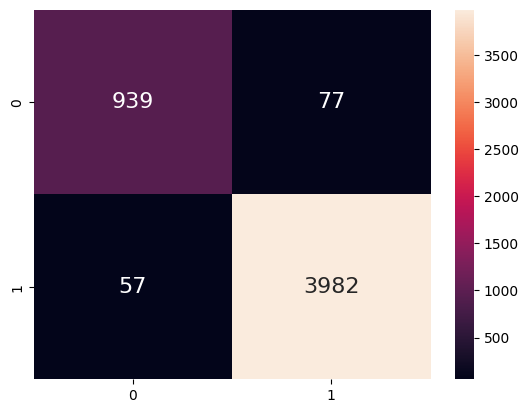

In [261]:
tp = 0
fp = 0
tn = 0
fn = 0

model.eval()
for i, (data, gt) in tqdm(enumerate(test_loader)):
    original_ts = data.to(device)
    reconstructed_ts = model(original_ts)
    loss = criterion(original_ts, reconstructed_ts)
    if loss >= loss_threshold:
        if gt == 1:
            tp += 1
        else:
            fp += 1
    else:
        if gt == 1:
            fn += 1
        else:
            tn += 1

print('[TP] {}\t[FP] {}'.format(tp, fp))
print('[FN] {}\t[TN] {}'.format(fn, tn))

precision = tp/(tp+fp if tp+fp else 1)
recall = tp/(tp+fn if tp+fp else 1)
f1 = 2*precision*recall/(precision+recall if precision+recall else 1)
print(f"F1 score = {f1}")

conf = [[tp,fp],[fn,tn]]
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')
plt.show()

Example of normal sample reconstruction

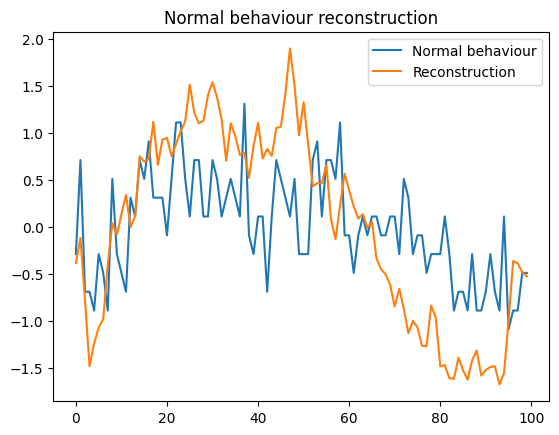

reconstruction loss = 0.6350623965263367
threshold = 1.0388856363296508


In [262]:
for i, (data, gt) in tqdm(enumerate(test_loader), disable=True):
    if gt==0:
        if i>1902:
            original_ts = data.to(device)
            reconstructed_ts = model(original_ts)
            loss = criterion(original_ts, reconstructed_ts)
            if loss>=loss_threshold: continue
            plt.plot(original_ts[0].cpu().detach().numpy()[0], label="Normal behaviour")
            plt.plot(reconstructed_ts[0].cpu().detach().numpy()[0], label="Reconstruction")
            plt.legend()
            plt.title("Normal behaviour reconstruction")
            plt.show()
            print(f"reconstruction loss = {criterion(original_ts, reconstructed_ts)}\nthreshold = {loss_threshold}")
            break

Example of a detected anomaly 

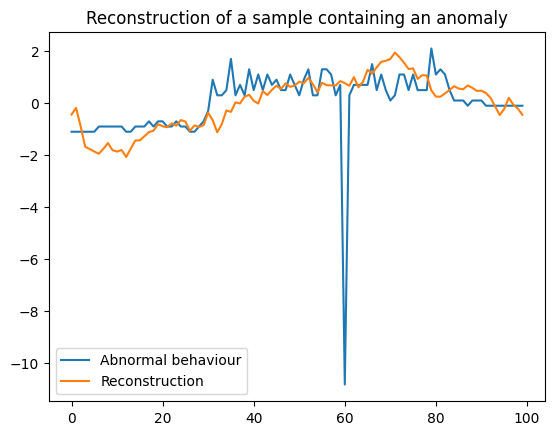

reconstruction loss = 1.7807282209396362
threshold = 1.0388856363296508


In [263]:
for i, (data, gt) in tqdm(enumerate(test_loader), disable=True):
    if gt==1:
        if i>2830:
            original_ts = data.to(device)
            reconstructed_ts = model(original_ts)
            loss = criterion(original_ts, reconstructed_ts)
            if loss<=loss_threshold: continue
            plt.plot(original_ts[0].cpu().detach().numpy()[0], label="Abnormal behaviour")
            plt.plot(reconstructed_ts[0].cpu().detach().numpy()[0], label="Reconstruction")
            plt.legend()
            plt.title("Reconstruction of a sample containing an anomaly")
            plt.show()
            print(f"reconstruction loss = {criterion(original_ts, reconstructed_ts)}\nthreshold = {loss_threshold}")
            break
            # plt.savefig(f"figs/{i}.jpg")
            # plt.clf()

Loss distribution

In [264]:
norm_losses = []
anom_losses = []

for i, (data, gt) in tqdm(enumerate(test_loader), disable=True):
    original_ts = data.to(device)
    reconstructed_ts = model(original_ts)
    loss = criterion(original_ts, reconstructed_ts)
    if gt==0:
        norm_losses.append(loss.cpu().detach().item())
    if gt==1:
        anom_losses.append(loss.cpu().detach().item())

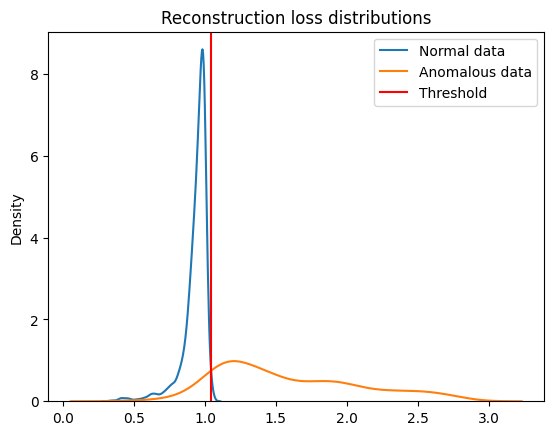

In [265]:
sns.kdeplot(sorted(norm_losses)[:-50], label='Normal data') # dont display values too far from threshold
sns.kdeplot(sorted(anom_losses)[:-350], label='Anomalous data') 
plt.axvline(loss_threshold, 0.0, 10, color='r', label='Threshold')
plt.title("Reconstruction loss distributions")
plt.legend()
plt.show()